# Homework 03: Projects

### <p style="text-align: right;"> &#9989; Kyle Taft


It is time to start working on your project. So let's start from the beginning.

Deadline: **Sunday, November 19 at 11:59PM**

Total points: **22**

# Part 0. Define your goal (4 points)

Clearly define the goal of your project. Be specific!


### Answer:
**Goal:** The goal of my project is to develop a supervised regression machine learning model that accurately predicts the discrete energy levels and gamma-ray transitions of a given experimental experimental nuclear decay spectrum that contains unwanted scattering energy counts.

# Part 1. Exploratory Data Analysis (4 points)

Give a comprehensive description of your data with text and code. For example, do you have one dataset or multiple datasets ? Are you going to merge them? what data does your dataset contain? What do the rows and columns represent? If you are doing image classification: what does each image represent? How much data do you have? How big is your dataset? How many categorical vs numerical features do you have and how are you going to handle it?How was obtained? Is it real world data or simulation data? Is it a time series? What type is your data, _e.g._ int, float, object, string? 

**Data cleaning:** Start performing data cleaning. Are there any missing values? How are you encoding the data? explain your choice. If you have multiple datasets, how are you handling them? How are you splitting your data?

**Visualization:** Make plots showing characteristics of the data. If you are doing regression on time series data, make plots showing historical events of importance. What other information do you have that are not contained in the dataset, but that are important for understanding data?

**Statistics:** Show the distribution and correlations of your data. Calculate relevant statistics of your data _e.g._ mean, median, skew, kurtosis. 

**Unsupervised:** What unsupervised learning technique you think you can use here? Dimensionality Reduction? Clustering? You don't need to do them yet. Just describe what you think would be useful.

### Answer:
**Data Description:** I have 2 catagories of ~10000 simulated 2d spectra (Total Absorption vs Individual Energies). The two catagories are single coincidence (1 level that decays directly to ground state) and double coincidence (1 level that decays to the ground state with two seperate gammas). With these simple spectra it is possible to create more complicated spectra by adding individual spectra together. This is justified since we can have an isotope decay in a probablistic manner that the decay paths are independent of each other except for the constraint that the probabilies add up to unity. Therefore superposition is allowed.

Additionally with each spectra I have a label spectrum that contains the intensity values and location of the gamma rays of interest. This is the data that I will be trying to predict.

**Data Cleaning:** I do not have any need for traditional data cleaning or exploration since I am using simulated data that I created. However, I do need to create a function that will translate the labels from being sparse matricies into being energy coordinates to be able to be used in certain models. The label being a matrix is motivated for being used in image to image translation models. However, I am not using all image to image translation models.

In [1]:
# Data Cleaning Example
import numpy as np
def transform_label(label, single = True):
    """
    label: a single label from the dataset
    single: boolean, True if single, False if double
    :return: the coordinates of energies in the label
    """
    cord = np.unravel_index(np.argmax(label, axis=None), label.shape)[0:2] # find the max
    if single:
        cord = np.array([20*cord[1], 20*(511-cord[0])]) # convert to energy
        return np.pad(cord, (0, 2), 'constant', constant_values=(-1,-1)) # pad with -1 to make it 2x2 matrix using unphysical values
    else:
        # find the second max
        label[cord[0], cord[1]] = 0
        cord2 = np.unravel_index(np.argmax(label, axis=None), label.shape)[0:2]
        return np.array([20*cord[1], 20*(511-cord[0]), 20*cord2[1], 20*(511-cord2[0])])

#Example labels
single_label = np.load("/mnt/home/taftkyle/indiv_data/singles/single_test_label.npy")[0]
double_label = np.load("/mnt/home/taftkyle/indiv_data/doubles/double_test_label.npy")[1]

print("Single Label: \n", transform_label(single_label, ).reshape(2,2))
print("Double Label: \n", transform_label(double_label, single = False).reshape(2,2))

Single Label: 
 [[7120 7120]
 [  -1   -1]]
Double Label: 
 [[1060 3540]
 [2500 3540]]


In [2]:
# Visualize the data (example spectra)
import matplotlib.pyplot as plt

# Function to convert the matrix to energy values and counts:
def matrix_to_coords(array):
    xys = []
    values = []
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            xys.append((20*j,20*(511-i)))
            values.append(array[i,j])
    return np.asarray(xys), np.asarray(values)

# Load the first data point of test data:
single = np.load("/mnt/home/taftkyle/indiv_data/singles/raw_single_test.npy")[0]
double = np.load("/mnt/home/taftkyle/indiv_data/doubles/raw_double_test.npy")[1] # I loaded the second double because the first one is not as nice to visualize
single_label= np.load("/mnt/home/taftkyle/indiv_data/singles/single_test_label.npy")[0]
double_label = np.load("/mnt/home/taftkyle/indiv_data/doubles/double_test_label.npy")[1]

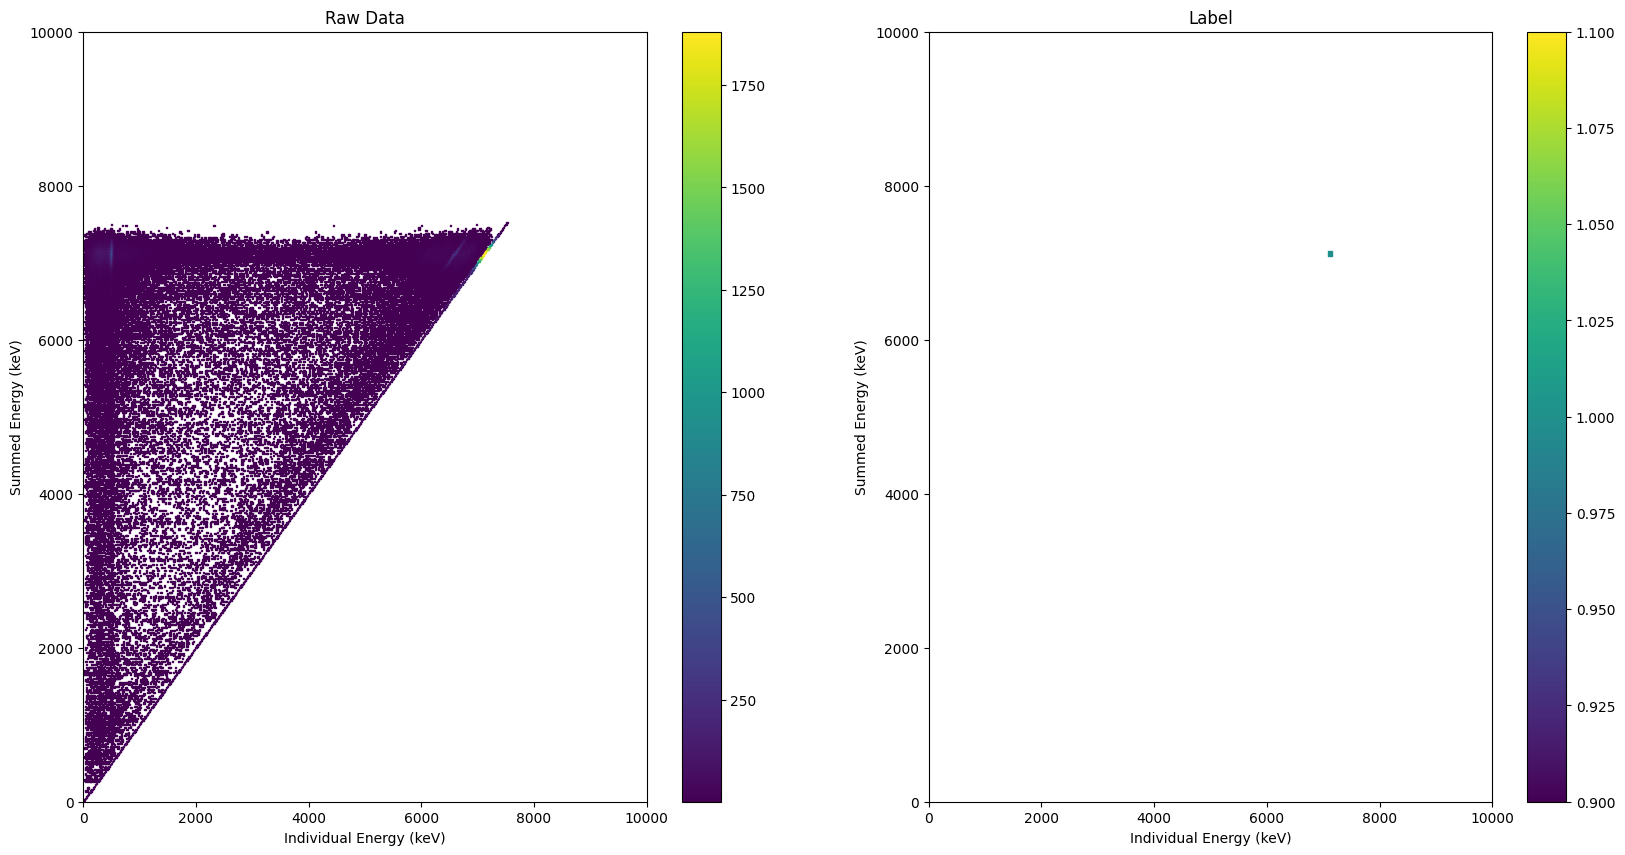

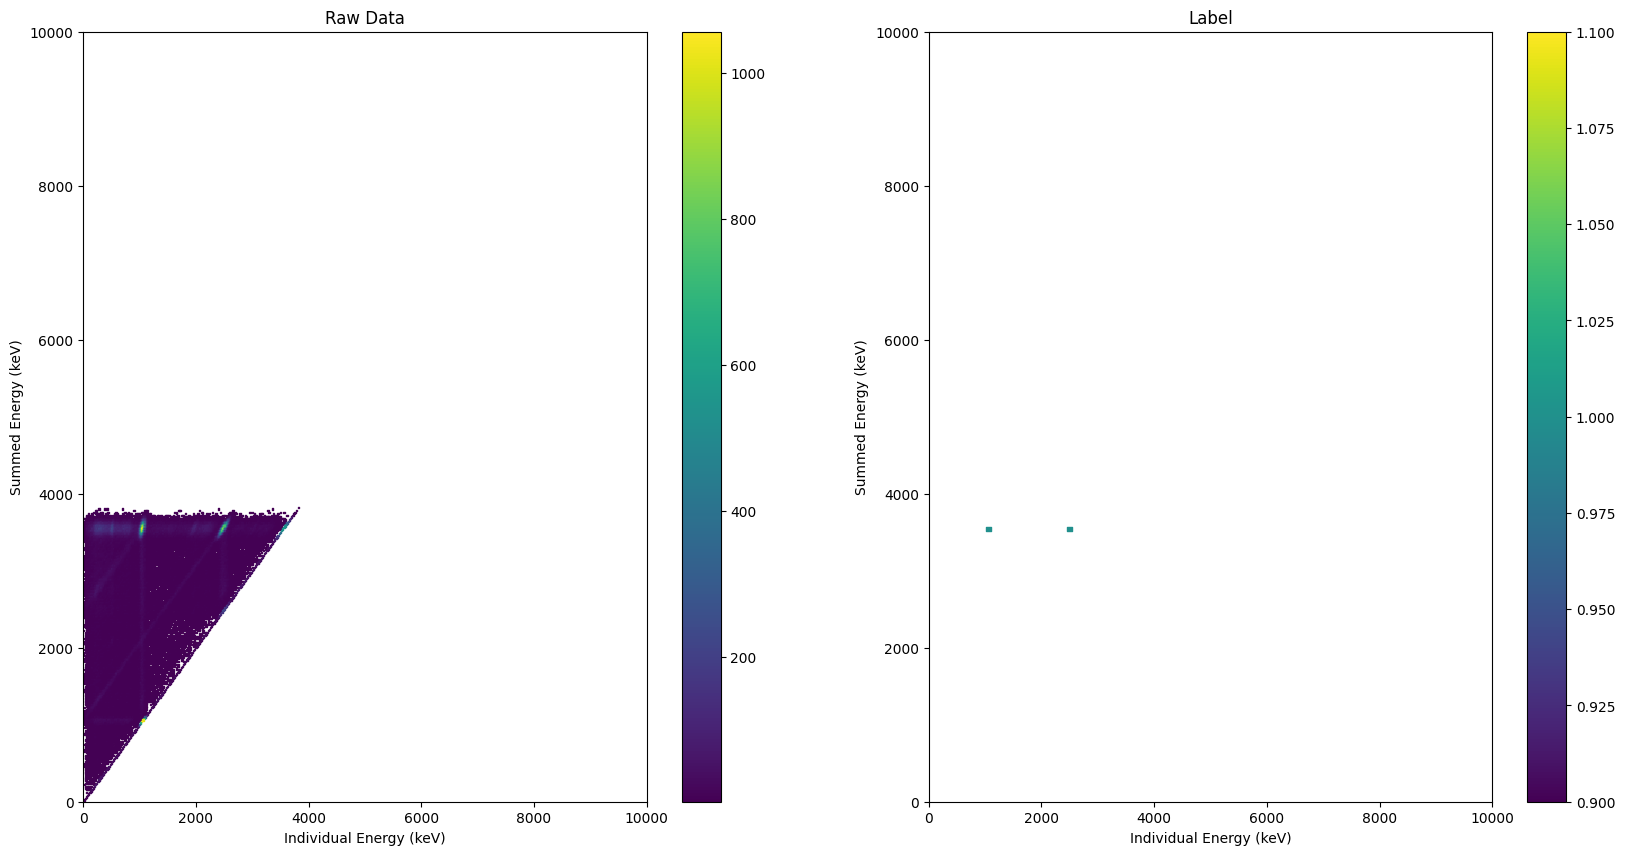

In [3]:
# Plot the data:
for example in [[single, single_label], [double, double_label]]:
    # Separate the data and label:
    data = example[0]
    label = example[1]

    #replace all values less than 1 with nan in order to appear white on graph
    data = data.astype(float)
    label = label.astype(float)
    data[data < 1.] = np.nan
    label[label < 1.] = np.nan

    # Subplot 1: Plot the raw data
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.title("Raw Data")
    plt.xlabel("Individual Energy (keV)")
    plt.ylabel("Summed Energy (keV)")
    points, vals = matrix_to_coords(data)
    plt.scatter(points[:,0],points[:,1], marker='s', c=vals, cmap='viridis', label="High Value Pixels", s=1)
    cbar = plt.colorbar()
    plt.xlim(0,10000)
    plt.ylim(0,10000)

    # Subplot 2: Plot the labels
    plt.subplot(1,2,2)
    plt.title("Label")
    plt.xlabel("Individual Energy (keV)")
    plt.ylabel("Summed Energy (keV)")
    points, vals = matrix_to_coords(label)
    plt.scatter(points[:,0],points[:,1], marker='s', c=vals, cmap='viridis', label="High Value Pixels", s=10)
    cbar = plt.colorbar()
    plt.xlim(0,10000)
    plt.ylim(0,10000)


**Statistics:** From the nature of my data a lot of the normal statistics are not useful. However, I can still report the distribution of the labels in my training set. The results go with what we would expect. We get a uniform distribution for the single label as they simply represent the energy domain. The individual gamma energies in the doubles show that we are more likely to get lower energies (below 5000) than higher one. This makes sense since when we cascade down from a higher energy we are more likely to get a lower energy than a higher one. For the double's levels we get the oppisite effect. When adding two energies together we are more likely to get a higher energy than a lower one. This is because we are adding two energies together and the probability of getting a higher energy is higher than getting a lower one.

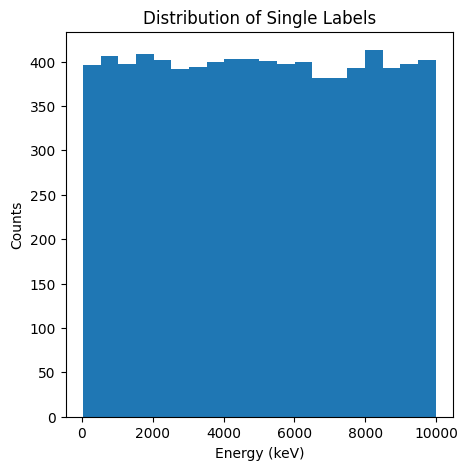

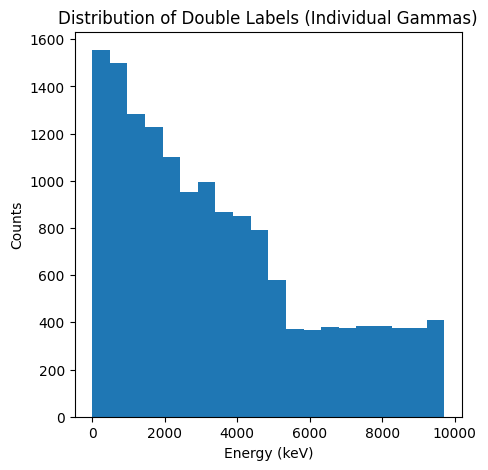

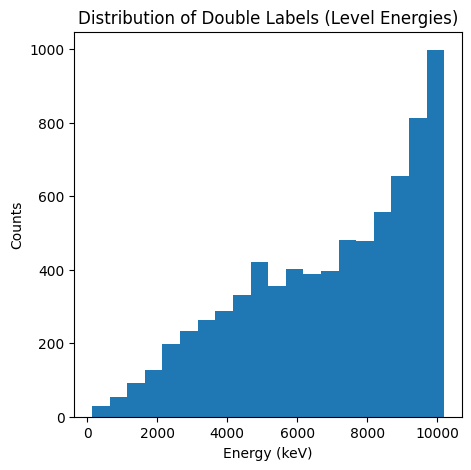

In [4]:
# Statistics of the data
single_labels = np.load("/mnt/home/taftkyle/indiv_data/singles/single_train_label.npy")
double_labels = np.load("/mnt/home/taftkyle/indiv_data/doubles/double_train_label.npy")

# # Get the energies of the labels:
single_energies = []
for label in single_labels:
    single_energies.append(transform_label(label)[0])

double_energies_indiv = []
double_energies_level = []
for label in double_labels:
    data_point = transform_label(label, single = False)
    double_energies_indiv.append(data_point[0])
    double_energies_indiv.append(data_point[2])
    double_energies_level.append(data_point[1])


# Plot the distribution:
plt.figure(figsize=(5,5))
plt.hist(single_energies, bins=20);
plt.title("Distribution of Single Labels")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts");

plt.figure(figsize=(5,5))
plt.hist(double_energies_indiv, bins=20);
plt.title("Distribution of Double Labels (Individual Gammas)")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts");

plt.figure(figsize=(5,5))
plt.hist(double_energies_level, bins=20);
plt.title("Distribution of Double Labels (Level Energies)")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts");

**Unsupervised:** There are multiple ways that unsupervised techniques could be used in this project. Mostly from the perspect of clustering we can perform actions such as trying to determine where the peaks are without the labels, or trying to determine the number of peaks in a spectrum. This could be done by using a clustering algorithm such as k-means. 

# Part 2. Define a Metric (4 points)

How do you know that your model is doing well, _e.g._ RMSE, Log loss, sparse categorical cross entropy, accuracy? Explain your choice and write the mathematical equation for it using LaTeX. What is your loss function? Are there already analytical models? How do they perform with your metric? 

**Optimization:** what optimization method are you going to use? If you don't know what it is look at the documentation of your model on `sklearn` or `tensorflow`.


### Answer:
**Metric and Loss Function:** The metric and loss that I will be using is the mean squared error. This is a good metric to use since it is a regression problem and I can use it directly to compare predicted values to my labels. The equation for the mean squared error is:

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^2$$

**Optimization:** The optimization method that I will be using is the Adam optimizer. This is a good optimizer to use since it is a combination of the RMSProp and the momentum optimizer.

# Part 3. Create a Baseline (4 points)

Before you start using complex models look at the performance of the simplest model. If the simplest model gets a score of 99.9999999%, then what is the point of using complex, expensive models? No one wants to waste time and money? What is the simplest model that you can throw at your data? Regression -> Linear Regression, Classification -> Logistic regression or a random classifier. How do these model perform on your data? The score of your simplest model is your baseline and your other ML models should do better than this (remember that we had 90% chance of being right on the MNIST dataset). 

This will require some hyperparameter tuning, cross-validation.

**Visualization:** Make plots of the learning curve, train-validation-test curves, timing curves. How long does it take for your machine learning model to fit? 


In [53]:
# My baseline model will be taking the two highest energy pixels

# Note there is no need for a training set because we are not training a model

# Load the data:
single_test = np.load("/mnt/home/taftkyle/indiv_data/singles/raw_single_test.npy")
double_test = np.load("/mnt/home/taftkyle/indiv_data/doubles/raw_double_test.npy")

# Load the labels:
single_test_labels = np.load("/mnt/home/taftkyle/indiv_data/singles/single_test_label.npy")
double_test_labels = np.load("/mnt/home/taftkyle/indiv_data/doubles/double_test_label.npy")

# Transform the labels:
single_test_labels = np.array([transform_label(label) for label in single_test_labels])
double_test_labels = np.array([transform_label(label, single = False) for label in double_test_labels])


# Concatenate the data:
test = np.concatenate((single_test, double_test))
test_labels = np.concatenate((single_test_labels, double_test_labels))

# Reuse the function from before to find the two highest energy pixels:
test_pred = np.zeros((test.shape[0], 4))
for i in range(test.shape[0]):
    test_pred[i] = transform_label(test[i], single = False)

# Evaluate the model using MSE and MAE:
from sklearn.metrics import mean_squared_error
print("Test RMSE: ", mean_squared_error(test_labels, test_pred)**0.5)
print("Test MAE: ", np.mean(np.abs(test_labels - test_pred)))

Test RMSE:  4362.36597283613
Test MAE:  2957.906467405308


# Part 4. Other ML models (2 points)

Now run your data through your other ML models and compare with the baseline. Make a table with the score of your models. 

Due to the data being large and the models long to run I will use the first 100 train and test spectra for the evaluation. Unfortunately, by loading the pretrained models it does not give me opertunties to work with the different visualizations of things such as the train/test loss over the training. I will make sure to include the learning curves in my final report.

In [56]:
# Trainined in seperate scripts
from tensorflow import keras
import tensorflow_addons as tfa
VIT_model = keras.models.load_model("/mnt/home/taftkyle/vit100")
CNN_model = keras.models.load_model("/mnt/home/taftkyle/cnn100")

/mnt/home/taftkyle/anaconda3/envs/condaVenv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [82]:
# Produce all predictions
def get_predictions(model, x_data, batch_size = 30):
    # For the training data
    predictions = []
    iteration = 0
    for i in range(len(x_data)//batch_size):
        iteration = i
        prediction = model.predict(np.asarray(x_data[batch_size*i:batch_size*(i+1)]), verbose=0)
        prediction  =  prediction.reshape(batch_size,2,2)
        predictions.append(prediction)
        
    # Get the last batch
    prediction = model.predict(np.asarray(x_data[batch_size*(iteration+1):]), verbose=0)
    prediction  =  prediction.reshape(len(x_data[batch_size*(iteration+1):]),2,2)
    predictions.append(prediction)

    predictions = np.concatenate(predictions, axis=0)

    return predictions

In [ ]:
# Make predictions
train_data = np.concatenate((np.load("/mnt/home/taftkyle/indiv_data/singles/raw_single_train.npy")[0:50], np.load("/mnt/home/taftkyle/indiv_data/doubles/raw_double_train.npy")[0:50]), axis=0)
test_data = np.concatenate((np.load("/mnt/home/taftkyle/indiv_data/singles/raw_single_test.npy")[0:50], np.load("/mnt/home/taftkyle/indiv_data/doubles/raw_double_test.npy")[0:50]), axis=0)


CNN_train_predictions = get_predictions(CNN_model, train_data).reshape(100,4)
CNN_test_predictions = get_predictions(CNN_model, test_data).reshape(100,4)
VIT_train_predictions = get_predictions(VIT_model, train_data).reshape(100,4)
VIT_test_predictions = get_predictions(VIT_model, test_data).reshape(100,4)

In [81]:
# Load the labels:
single_train_labels = np.load("/mnt/home/taftkyle/indiv_data/singles/single_train_label.npy")[0:50]
double_train_labels = np.load("/mnt/home/taftkyle/indiv_data/doubles/double_train_label.npy")[0:50]
single_test_labels = np.load("/mnt/home/taftkyle/indiv_data/singles/single_test_label.npy")[0:50]
double_test_labels = np.load("/mnt/home/taftkyle/indiv_data/doubles/double_test_label.npy")[0:50]

# Transform the labels:
train_labels = np.concatenate((np.array([transform_label(label) for label in single_train_labels]), np.array([transform_label(label, single = False) for label in double_train_labels])), axis=0)
test_labels = np.concatenate((np.array([transform_label(label) for label in single_test_labels]), np.array([transform_label(label, single = False) for label in double_test_labels])), axis=0)


# Evaluate the model using MSE and MAE:
print("CNN Train RMSE: ", mean_squared_error(train_labels, CNN_train_predictions)**0.5)
print("CNN Train MAE: ", np.mean(np.abs(train_labels - CNN_train_predictions)))
print("CNN Test RMSE: ", mean_squared_error(test_labels, CNN_test_predictions)**0.5)
print("CNN Test MAE: ", np.mean(np.abs(test_labels - CNN_test_predictions)))

# Evaluate the model using MSE and MAE:
from sklearn.metrics import mean_squared_error
print("ViT Train RMSE: ", mean_squared_error(train_labels, VIT_train_predictions)**0.5)
print("ViT Train MAE: ", np.mean(np.abs(train_labels - VIT_train_predictions)))
print("ViT Test RMSE: ", mean_squared_error(test_labels, VIT_test_predictions)**0.5)
print("ViT Test MAE: ", np.mean(np.abs(test_labels - VIT_test_predictions)))



CNN Train RMSE:  489.91262037201705
CNN Train MAE:  383.99357568502427
CNN Test RMSE:  493.8789999564837
CNN Test MAE:  383.9878420138359
ViT Train RMSE:  100.51959002509521
ViT Train MAE:  73.65251461133361
ViT Test RMSE:  115.89447878474509
ViT Test MAE:  82.58929430365562


# Part 5. Make a plan for the rest (4 points)

Now that you have a baseline, how do you plan to improve your models? What kind of feature engineering can you do to improve your model? What other hyperparameter can you change? Optimization techniques? Unsupervised techniques?


I have already put in a lot of work in order to get my models into the shape they are now. I will continue to explore ViT and its hyperparameter space to see if there are more optimal solutions. Additionally, in order to make my model more useful I will add some more complex data that include intensity values in the spectra. This is more realistic to what we would want to get out of an experiment.

&#169; Copyright 2023, Department of Computational Mathematics, Science and Engineering at Michigan State University.